# Detecção de fraudes

Autora: Luana Fraga de Andrade Araujo

E-mail: luafraga1@hotmail.com

LinkedIn: www.linkedin.com/in/luana-fraga-63a794193/

Github: https://github.com/luanafraga

# Objetivo do projeto

O objetivo deste projeto é a **detecção**, e consequentemente a **diminuição de fraudes** em transações financeiras, identificando os **padrões de compra** de cada cliente a partir de informações como nome, cartão de crédito e documentos pessoais.

# Base de dados

A base de dados possui informações sobre:

   - **step**: mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

   - **type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. 
(caixa-de-entrada, caixa-de-saida, débito, pagamento e transferência)

   - **amount**: valor da transação em moeda local.

   - **nameOrig**: cliente que iniciou a transação

   - **oldbalanceOrg**: saldo inicial antes da transação
   
   - **newbalanceOrig**: novo saldo após a transação

   - **nameDest**: cliente que é o destinatário da transação

   - **oldbalanceDest**: destinatário do saldo inicial antes da transação. 

   - **newbalanceDest**: novo destinatário do saldo após a transação. 

   - **isFraud**: São as transações feitas pelos agentes fraudulentos dentro da simulação. 

   - **isFlaggedFraud**: O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.

# Importação de Pacotes

In [1]:
import pandas as pd
import numpy as np

# para visualização dos gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling

# para balanceamento do target
from imblearn.over_sampling import SMOTE

In [2]:
# para criação e validação dos modelos de machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# para garantir a replicabilidade do código
SEED=42

In [3]:
sns.set_palette('pastel')
sns.set_style('white')

# Leitura dos dados

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

In [5]:
dados = pd.read_csv('fraud_dataset_example.csv')
dados

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0


In [6]:
print(f'Nosso Conjunto de Dados inicial tem {dados.shape[0]} linhas e {dados.shape[1]} colunas.')

Nosso Conjunto de Dados inicial tem 101613 linhas e 11 colunas.


# Renomeando as colunas

In [7]:
colunas = {'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude'}

In [8]:
dados = dados.rename(columns=colunas)
dados

,tempo,tipo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2,fraude,super_fraude
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0


# Informações do DataFrame

In [9]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tempo             101613 non-null  int64  
 1   tipo              101613 non-null  object 
 2   valor             101613 non-null  float64
 3   cliente1          101613 non-null  object 
 4   saldo_inicial_c1  101613 non-null  float64
 5   novo_saldo_c1     101613 non-null  float64
 6   cliente2          101613 non-null  object 
 7   saldo_inicial_c2  101613 non-null  float64
 8   novo_saldo_c2     101613 non-null  float64
 9   fraude            101613 non-null  int64  
 10  super_fraude      101613 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


O DataFrame consta com **11 variáveis**.

In [10]:
dados.isnull().values.any()

False

Não foi verificado **nenhum dado nulo**.

In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' %x)
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
tempo,101613.00,8.52,1.82,1.00,8.00,9.00,10.00,10.00
valor,101613.00,174090.07,345019.90,0.32,10016.59,53385.41,212498.40,10000000.00
saldo_inicial_c1,101613.00,907175.26,2829575.28,0.00,0.00,20190.47,194715.00,38939424.03
novo_saldo_c1,101613.00,923499.25,2867318.71,0.00,0.00,0.00,219217.76,38946233.02
saldo_inicial_c2,101613.00,881042.80,2399949.06,0.00,0.00,21058.00,591921.70,34008736.98
novo_saldo_c2,101613.00,1183998.10,2797761.08,0.00,0.00,51783.43,1063121.64,38946233.02
fraude,101613.00,0.00,0.03,0.00,0.00,0.00,0.00,1.00
super_fraude,101613.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [12]:
dados.describe(include=[object])

,tipo,cliente1,cliente2
count,101613,101613,101613
unique,5,101613,52280
top,PAYMENT,C1231006815,C985934102
freq,40062,1,78


Para começar a análise, vamos utilizar o método **.describe()** para entender alguns métodos estatísticos que temos dentro da base de dados. O método describe() fornece as informações sobre:

- Para variáveis **quantitativas**:

   - **count** - Conta a quantidade de número de valores não vazios. Com esses valores podemos entender melhor o tamanho da amostra.

   - **mean** - O valor médio, em média aritmética. 

   - **std** - O desvio padrão. É a medida de como os dados se dispersam em relação à média, ou seja, o quanto eles estão espalhados.

   - **min e max** - Valores que auxiliam a identificar a amplitude da amostra, entre o valor mínimo e máximo.

   - **quartis** - Valores que nos mostram de que forma os dados foram distribuídos, por exemplo em 50% é a mediana e metade dos valores são inferiores a X valor, a outra metade é superior àquele valor.


- Para variáveis **categóricas**:

    - **unique** é a quantidade de valores únicos

    - **top** é o valor mais comum

    - **freq** é a frequência do valor mais comum

# Análise exploratória

## Verificando quantidade de fraudes e super fraudes

In [13]:
dados.groupby('fraude').tempo.count()

fraude
0    101497
1       116
Name: tempo, dtype: int64

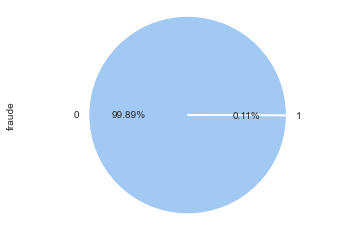

In [14]:
dados['fraude'].value_counts().plot(kind='pie', autopct='%.2f%%')
plt.axis('equal')
plt.show()

In [15]:
dados.groupby('super_fraude').tempo.count()

super_fraude
0    101613
Name: tempo, dtype: int64

Conseguimos verificar no nosso dataset **116 fraudes** (0,11% do total de transações) e **nenhuma super-fraude**.

## Tipos de transações financeiras totais realizadas

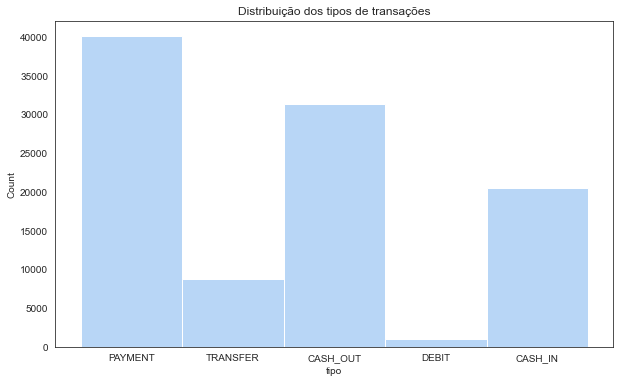

In [16]:
fig = plt.figure(figsize=(10,6))
sns.histplot(dados['tipo'], kde=False)
plt.title('Distribuição dos tipos de transações')
plt.show()

## Tipos de transações financeiras realizadas - Fraude

In [17]:
dados_fraude = dados['fraude'] == 1
dados_fraude = dados[dados_fraude]
dados_fraude

,tempo,tipo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2,fraude,super_fraude
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
77745,10,CASH_OUT,277970.88,C489647033,0.00,0.00,C571514738,0.00,277970.88,1,0
90070,10,TRANSFER,93810.76,C481501970,93810.76,0.00,C1262577882,0.00,0.00,1,0
90071,10,CASH_OUT,93810.76,C1190429229,93810.76,0.00,C2104652067,4096048.05,4189858.81,1,0
99371,10,TRANSFER,503405.88,C1446009472,503405.88,0.00,C2010733400,0.00,0.00,1,0


In [18]:
dados_fraude.describe().T

,count,mean,std,min,25%,50%,75%,max
tempo,116.00,5.75,2.87,1.00,4.00,6.00,8.00,10.00
valor,116.00,541578.42,1535066.59,164.00,17246.00,39077.82,296154.59,10000000.00
saldo_inicial_c1,116.00,552710.14,1710291.31,0.00,13706.33,30521.02,248659.64,12930418.44
novo_saldo_c1,116.00,29080.48,274818.99,0.00,0.00,0.00,0.00,2930418.44
saldo_inicial_c2,116.00,227348.22,1314005.99,0.00,0.00,0.00,11226.75,13010502.78
novo_saldo_c2,116.00,658211.23,2063281.64,0.00,0.00,2277.96,185718.64,13071229.35
fraude,116.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
super_fraude,116.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [19]:
df1 = dados_fraude.groupby('tipo').tipo.count()
df1

tipo
CASH_OUT    59
TRANSFER    57
Name: tipo, dtype: int64

In [20]:
df2 = pd.DataFrame(df1).T
df2

tipo,CASH_OUT,TRANSFER
tipo,59,57


<AxesSubplot:title={'center':'Tipos de transações resultando em fraude'}, xlabel='tipo'>

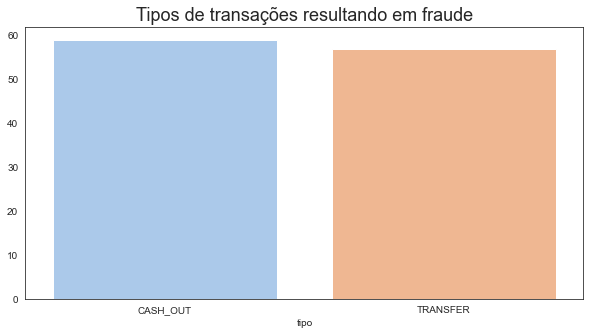

In [21]:
plt.figure(figsize = (10,5))
plt.title('Tipos de transações resultando em fraude', fontsize=18)
sns.barplot(data=df2)

As ocorrências de **fraudes** no nosso dataset foram através das transações: **Cash-out e Transferência**.

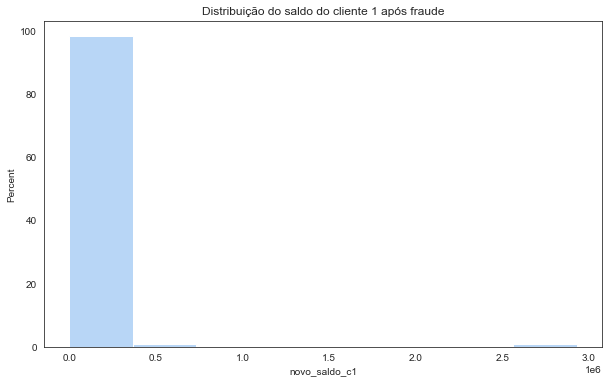

In [22]:
fig = plt.figure(figsize=(10,6))
sns.histplot(dados_fraude['novo_saldo_c1'], stat="percent")
plt.title('Distribuição do saldo do cliente 1 após fraude')
plt.show()

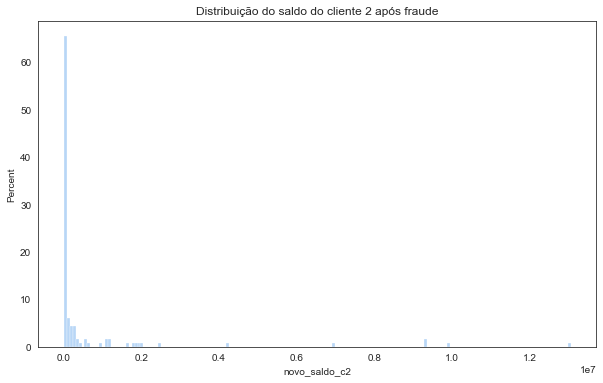

In [23]:
fig = plt.figure(figsize=(10,6))
sns.histplot(dados_fraude['novo_saldo_c2'], stat="percent")
plt.title('Distribuição do saldo do cliente 2 após fraude')
plt.show()

Conseguimos verificar também que a grande maioria das fraudes **esvaziam os fundos** do cliente 1, transferindo para outra conta e depois **sacando do sistema.**

## Tipos de transações financeiras realizadas - Não Fraude

In [24]:
dados_nao_fraude = dados['fraude'] == 0
dados_nao_fraude = dados[dados_nao_fraude]
dados_nao_fraude

,tempo,tipo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2,fraude,super_fraude
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.00,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0


In [25]:
df3 = dados_nao_fraude.groupby('tipo').tipo.count()
df3

tipo
CASH_IN     20540
CASH_OUT    31251
DEBIT        1012
PAYMENT     40062
TRANSFER     8632
Name: tipo, dtype: int64

In [26]:
df4 = pd.DataFrame(df3).T
df4

tipo,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
tipo,20540,31251,1012,40062,8632


<AxesSubplot:title={'center':'Tipos de transações não fraude'}, xlabel='tipo'>

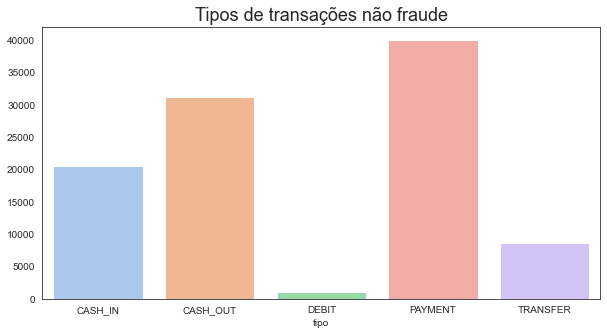

In [27]:
plt.figure(figsize = (10,5))
plt.title('Tipos de transações não fraude', fontsize=18)
sns.barplot(data=df4)

In [28]:
dados_nao_fraude.describe().T

,count,mean,std,min,25%,50%,75%,max
tempo,101497.00,8.53,1.82,1.00,8.00,9.00,10.00,10.00
valor,101497.00,173670.07,341101.61,0.32,10005.52,53386.53,212434.54,6419835.27
saldo_inicial_c1,101497.00,907580.37,2830581.02,0.00,0.00,20181.00,194571.06,38939424.03
novo_saldo_c1,101497.00,924521.47,2868782.32,0.00,0.00,0.00,220065.78,38946233.02
saldo_inicial_c2,101497.00,881789.90,2400810.91,0.00,0.00,21173.00,592635.66,34008736.98
novo_saldo_c2,101497.00,1184599.02,2798441.21,0.00,0.00,52025.86,1065763.69,38946233.02
fraude,101497.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
super_fraude,101497.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Transformação de variáveis categóricas em numéricas

Vamos utilizar o **One-Hot-enconding**, que criará colunas e dirá se existe ou não determinada variável, sem nenhum tipo de hierarquia, isto é, todas as colunas têm 0 ou 1. Portanto, uma coluna binária. Para fazermos o One-Hot-enconding, podemos utilizar um método do Pandas chamado **Dummy**.

In [29]:
dados = pd.get_dummies(data=dados, columns=['tipo'])
dados

,tempo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2,fraude,super_fraude,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101608,10,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0,0,0,0,1,0
101609,10,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0,0,1,0,0,0
101610,10,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0,0,0,0,1,0
101611,10,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0,0,0,0,0,1


# Removendo variáveis

Removeremos as colunas 'cliente 1' e 'cliente 2', porque os nomes dos clientes não farão diferença no nosso modelo. Outra coluna que podemos remover é a "super_fraude", porque ela só tem zeros e não ocorreu nenhuma super_fraude.

In [30]:
dados = dados.drop(['cliente1', 'cliente2', 'super_fraude'], axis=1)
dados

,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2,fraude,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,1
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,1,0,0,0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101608,10,7477.02,785.00,0.00,0.00,0.00,0,0,0,0,1,0
101609,10,282252.35,220339.29,0.00,95156.01,91286.97,0,0,1,0,0,0
101610,10,17289.01,0.00,0.00,0.00,0.00,0,0,0,0,1,0
101611,10,1347146.45,1605.00,0.00,541639.43,2186953.43,0,0,0,0,0,1


# Balanceamento dos dados

In [31]:
dados.groupby('fraude').tempo.count()

fraude
0    101497
1       116
Name: tempo, dtype: int64

Como já tínhamos verificado na análise exploratória, nossa variável target **Fraude** está **desbalanceada**. Precisamos fazer o rebalanceamento dos dados para equilibrar as classes, diminuindo a probabilidade do modelo tornar-se tendencioso para uma determinada classe.

Para este projeto, será utilizado o método **oversampling** pois não remove informações do sistema. Para aplicar o oversampling, será utilizado o método **SMOTE()**. Para balancear o dataset, são criadas linhas sintéticas com base nos dados já existentes.

In [32]:
smote = SMOTE(random_state=SEED)

In [33]:
x = dados.drop('fraude', axis=1)
y = dados['fraude']

In [34]:
x_resampled, y_resampled = smote.fit_resample(x,y)

In [35]:
dados_balanceados = pd.concat([y_resampled, x_resampled], axis=1)
dados_balanceados

,fraude,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,1,0
1,0,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,1,0
2,1,1,181.00,181.00,0.00,0.00,0.00,0,0,0,0,1
3,1,1,181.00,181.00,0.00,21182.00,0.00,0,1,0,0,0
4,0,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
202989,1,5,17608.96,17608.96,0.00,0.00,0.00,0,0,0,0,1
202990,1,7,12116.29,12116.29,0.00,0.00,0.00,0,0,0,0,1
202991,1,1,231612.88,231612.88,0.00,1945.59,9370.60,0,0,0,0,0
202992,1,9,547325.14,547325.14,0.00,0.00,0.00,0,0,0,0,1


In [36]:
print(f'Nosso Conjunto de Dados balanceados tem {dados_balanceados.shape[0]} linhas e {dados_balanceados.shape[1]} colunas.')

Nosso Conjunto de Dados balanceados tem 202994 linhas e 12 colunas.


In [37]:
dados_balanceados.groupby('fraude').tempo.count()

fraude
0    101497
1    101497
Name: tempo, dtype: int64

# Matriz de Correlação

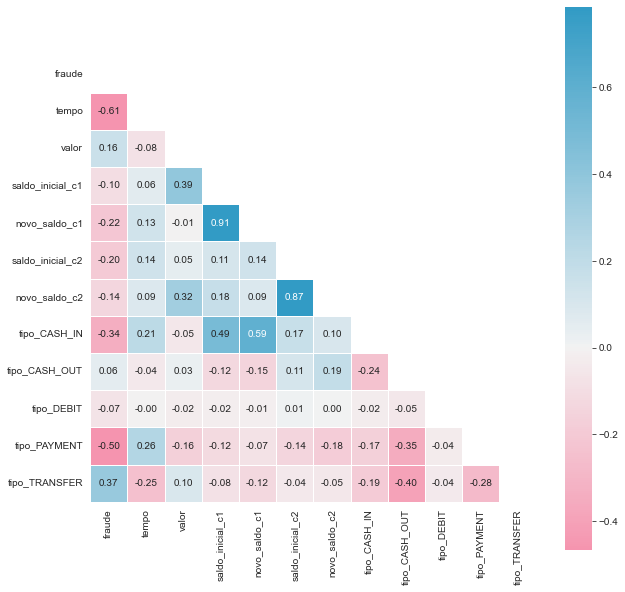

In [38]:
matrix_corr = dados_balanceados.corr()
mask = np.zeros_like(matrix_corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(matrix_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, robust=True, annot= True, fmt=".2f")

 A matriz de correlação nos fornece hipóteses que permite identificar quais são as variáveis que influenciam positiva ou negativamente na identificação de uma classe da variável alvo. 
 
 Podemos verificar que a variável **FRAUDE** tem correlação:

**Positiva** com a variável **TRANSFERÊNCIA** (Clientes que fazem transferências, são os com mais probabilidade de efetuar uma fraude)
    
**Negativa** com:

   - as variáveis **PAGAMENTO e CASH IN** (Clientes que fazem estes tipos de movimentações, são os com menos probabilidade de efetuar uma fraude)
   
   
   - a variável **TEMPO**. (Ex: Cliente pode fazer seus pagamentos durante a manhã e a fraude ocorre durante um período diferente, como à noite)

# Machine Learning

## Definindo as features (dados de entrada) e os labels (dados de saída)

In [39]:
x = dados_balanceados.iloc[:, 1:].values
y = dados_balanceados.iloc[:, 0].values

## Criação de bases de treino e teste

In [40]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.25, random_state=SEED)

## Regressão Logística

In [41]:
#criando o modelo
lr = LogisticRegression(max_iter=1000, random_state=SEED)

#treinando o modelo
lr.fit(x_treino, y_treino)

#criando previsões
y_pred =lr.predict(x_teste)

### Avaliação do modelo

Com o modelo treinado e as previsões feitas, utilizaremos as seguintes métricas para avaliação do modelo:

   **Acurácia**, que mostra a taxa de acerto do modelo;
   
   **Precisão**, que é a proporção de predições corretas de uma categoria em relação a todas as predições dessa categoria;
   
   **Recall**, que é a proporção de predições corretas da categoria alvo;
   
   **F1**, que é a média harmonica entre a precisão e o recall;
   
   **Matriz de confusão**, que mostra a contagem dos acertos e dos erros do modelo de machine learning.
   
   **Curva Roc**, que avalia o desempenho do modelo a partir da relação entre a taxa de verdadeiros positivos e a taxa de falsos positivos para diferentes limites. Nós queremos que a nossa curva ROC esteja mais próxima do canto superior esquerdo porque ele vai maximizar a minha taxa de verdadeiros positivos e vai minimizar a minha taxa de falsos positivos.

In [42]:
print("Acurácia:",metrics.accuracy_score(y_teste, y_pred))
print("Precisão:",metrics.precision_score(y_teste, y_pred))
print("Recall:",metrics.recall_score(y_teste, y_pred)) 
print("F1:",metrics.f1_score(y_teste, y_pred))

Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


### Matriz de Confusão

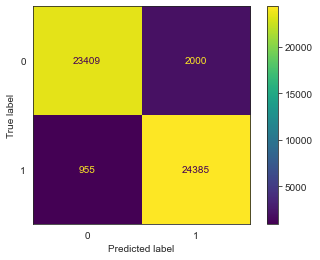

In [43]:
cm = confusion_matrix(y_teste, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Curva ROC

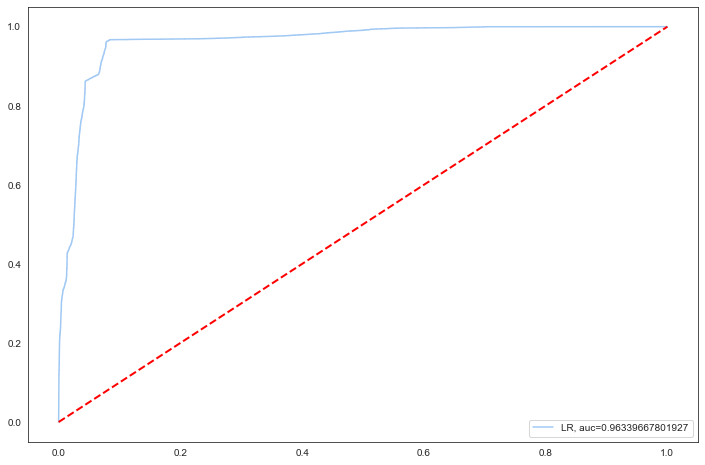

In [44]:
y_pred_proba = lr.predict_proba(x_teste)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_teste, y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

Com a **Curva Roc** conseguimos validar o modelo em si. Ela é característica de operação do receptor e quanto mais perto de 1 a curva azul fica, melhor ela é. Valor de **AUC** bom: 0.963. 

## Árvore de decisão

Utilizaremos como modelo de comparação (com a regressão logística que fizemos anteriormente) a Árvore de decisão. 

In [45]:
#criando o modelo
dt = DecisionTreeClassifier(max_depth = 5, random_state=SEED)

#treinando o modelo
model = dt.fit(x_treino, y_treino)

#criando previsões
y_pred = dt.predict(x_teste)

### Avaliação do modelo

In [46]:
print("Acurácia:",metrics.accuracy_score(y_teste, y_pred))
print("Precisão:",metrics.precision_score(y_teste, y_pred))
print("Recall:",metrics.recall_score(y_teste, y_pred)) 
print("F1:",metrics.f1_score(y_teste, y_pred))

Acurácia: 0.9622849711324362
Precisão: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943


### Matriz de confusão

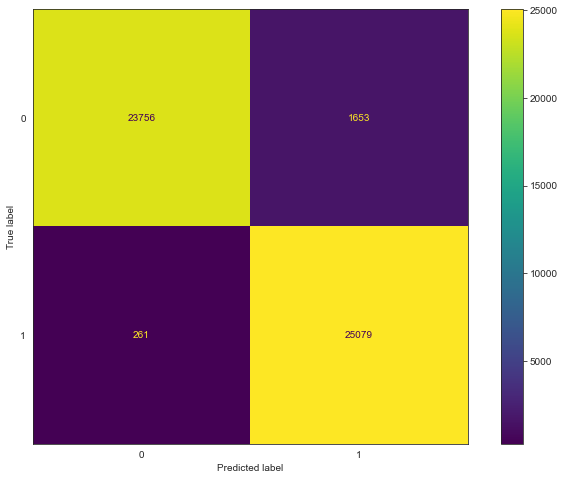

In [47]:
cm = confusion_matrix(y_teste, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Verificamos pela matriz de confusão que esse nosso novo modelo já está relativamente melhor que o anterior.

### Curva ROC

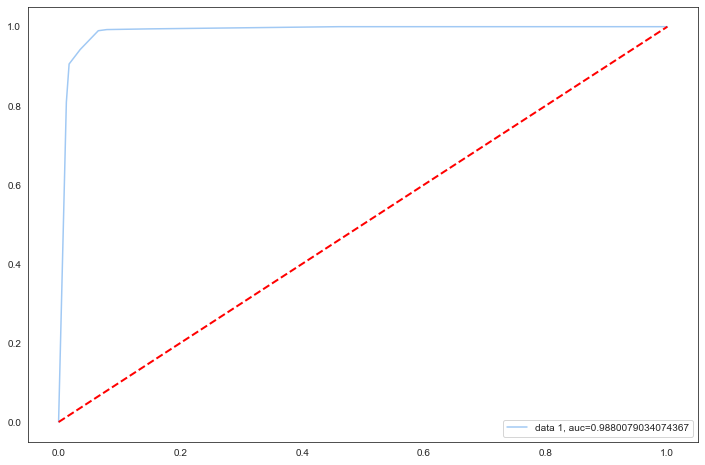

In [48]:
y_pred_proba = dt.predict_proba(x_teste)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

A nova curva **ROC** está excepcionalmente boa! Com **AUC** de valor **0.988**. Quer dizer que a área sobre a curva está bem alta. É possível perceber que ela está subindo de forma muito mais linear, ou seja, está bem mais suave que a outra. Atinge o ponto 1.0 no eixo y muito mais rápido do que as outras curvas anteriores, da regressão logística, logo, concluímos que este modelo está bem melhor.

## Random Forest

Utilizaremos mais um modelo para comparação, o Random Forest, que possui várias árvores de decisão. Em tese, o Random Forest é melhor que o algoritmo de decision tree.

In [49]:
#criando o modelo
rf = RandomForestClassifier(max_depth= 5, random_state = SEED)

#treinando o modelo
model = rf.fit(x_treino, y_treino)

#criando previsões
y_pred = rf.predict(x_teste)

### Avaliação do modelo

In [50]:
print("Acurácia:",metrics.accuracy_score(y_teste, y_pred))
print("Precisão:",metrics.precision_score(y_teste, y_pred))
print("Recall:",metrics.recall_score(y_teste, y_pred))
print("F1:",metrics.f1_score(y_teste, y_pred))

Acurácia: 0.9723738398786183
Precisão: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


### Matriz de confusão

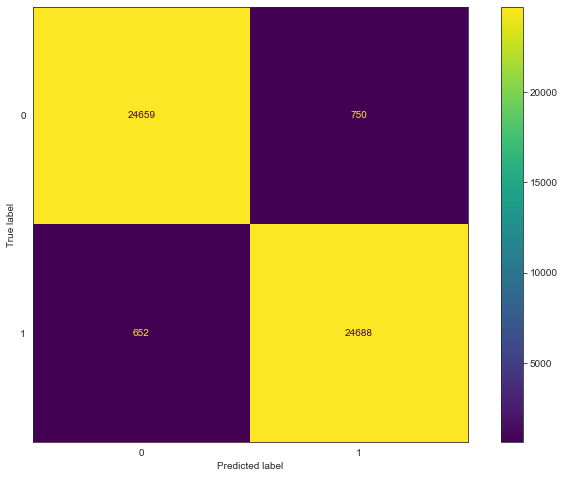

In [51]:
cm = confusion_matrix(y_teste, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Curva ROC

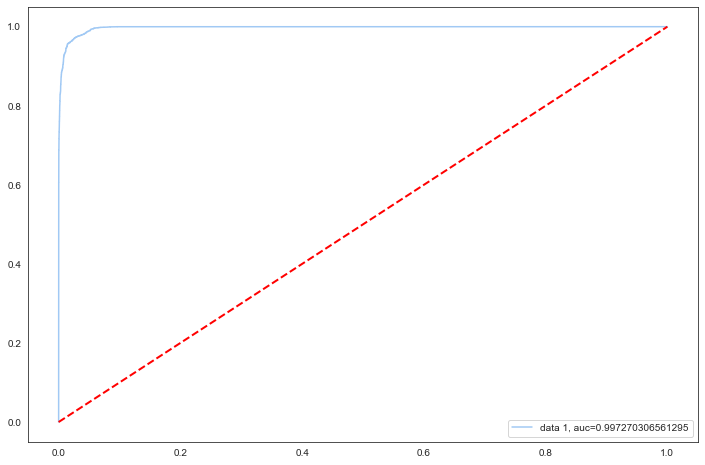

In [52]:
y_pred_proba =  rf.predict_proba(x_teste)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred_proba)
auc = metrics.roc_auc_score(y_teste, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

Tivemos uma acurácia bem alta e outros valores também, todos em torno de **97%**.
Já utilizando a matriz de confusão, não tivemos resultados tão bons quanto os anteriores.
O resultado da curva ROC foi de **0.997**, melhor que a anterior. Até fez uma "curvinha" próxima ao ponto 1.0 no eixo y e não mais uma reta, que aparecia na anterior. Ela sobe mais rápido e quanto mais ráida é a subida, mais suave é a curva. 

## Análise das Métricas

In [53]:
classifiers = [ 
    LogisticRegression(max_iter=1000, random_state=SEED),
    DecisionTreeClassifier(max_depth = 5, random_state=SEED),
    RandomForestClassifier(max_depth= 5, random_state=SEED)]

LogisticRegression
****Resultados****
Accuracy: 0.9417722516699837
Precision: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975
DecisionTreeClassifier
****Resultados****
Accuracy: 0.9622849711324362
Precision: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943
RandomForestClassifier
****Resultados****
Accuracy: 0.9723738398786183
Precision: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


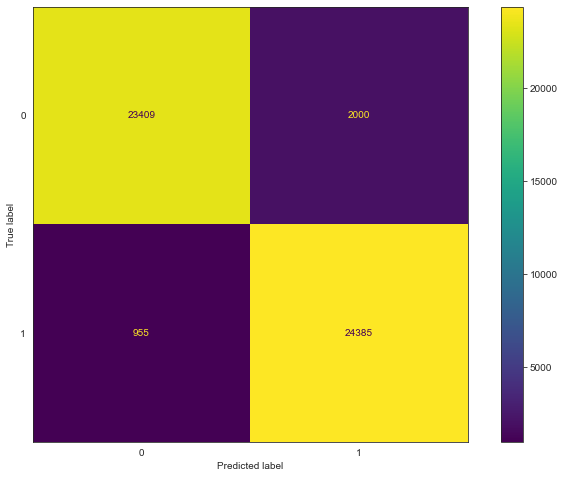

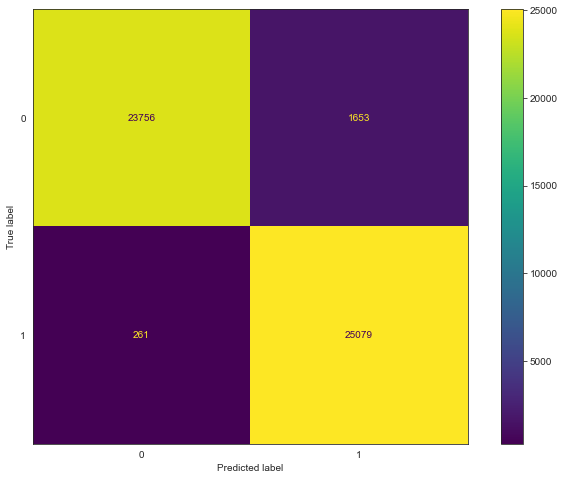

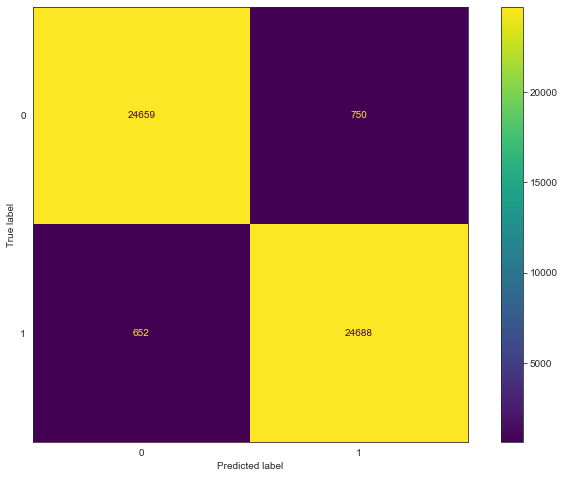

In [54]:
for clf in classifiers:
  clf.fit(x_treino, y_treino)
  name = clf.__class__.__name__
  print("="*30)
  print(name)
  print('****Resultados****')
  y_pred = clf.predict(x_teste)
  print("Accuracy:", metrics.accuracy_score(y_teste, y_pred))
  print("Precision:", metrics.precision_score(y_teste, y_pred))
  print("Recall:", metrics.recall_score(y_teste, y_pred))
  print("F1:", metrics.f1_score(y_teste, y_pred))
  
  cm = confusion_matrix(y_teste, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()

Para a análise das métricas, começaremos verificando as métricas gerais e analisando qual está melhor. As métricas da regressão logística estão com valores inferiores se comparados aos das outras métricas. A do Random Forest está bem melhor. Sua acurácia, por exemplo, é de **97%**. A única métrica de valor maior, em relação ao Random Forest, é a de Recall, da Árvore de Decisão, de **98,97%** contra **97,42%** no Random Forest. Então, no geral, o **Random Forest** se saiu melhor, o que já era esperado, considerando as várias árvores que ele contém.

## Melhorando o modelo Random Forest

Utilizaremos o método **Randomizedsearchcv** que faz a melhoria do modelo automaticamente, basta adicionar os hiperparâmetros que desejamos melhorar e ele fará a melhoria com base no modelo.

### Definição dos parâmetros do Random Forest 

In [55]:
n_estimators = np.arange(20, 200, step=20)
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(2, 10, step=1))
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

O critério de impureza **Gini** serve para medir a frequência com que um elemento escolhido aleatoriamente pode ser identificado incorretamente. Quanto menor o valor, mais puros são os dados e menor o erro cometido.

O critério de **entropia** para ganho de informação é o menor número médio de perguntas binárias (sim ou não) necessário para identificar a saída de uma fonte. Esse valor informa quão informativas são as características para serem selecionadas. Desse modo, quanto maior a entropia, maior o conteúdo da informação.

In [56]:
param_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap}

### Aplicando o RandomizedSearchCv

In [57]:
rforest = RandomForestClassifier(random_state=SEED)

In [58]:
random_cv = RandomizedSearchCV(
    rforest, param_grid, n_iter=5, cv=3, scoring="recall", n_jobs=-1, random_state = SEED)

o **Recall** é a métrica que desejávamos melhorar, pois estamos lidando com casos de fraude. 
Não queremos deixar o cliente insatisfeito e fazer com que ele receba uma notificação de que ele está fazendo uma fraude, sendo que ele não está, porém, é muito mais perigoso deixar passar uma fraude que deixar com que os avisos aconteçam. 

### Treinando o random_cv

In [59]:
%%time
rcv = random_cv.fit(x, y)

/Users/luana/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/luana/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/luana/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

CPU times: user 43.5 s, sys: 1.11 s, total: 44.6 s
Wall time: 3min 55s


### Verificando os cinco parâmetros escolhidos

In [60]:
pd.DataFrame(rcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,116.01,1.91,2.39,0.03,160,8,1,sqrt,8,gini,False,"{'n_estimators': 160, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini', 'bootstrap': False}",0.99,1.00,0.99,0.99,0.00,1
1,40.98,20.40,1.84,1.02,120,8,4,sqrt,4,gini,True,"{'n_estimators': 120, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}",0.96,1.00,0.97,0.98,0.01,2
2,36.13,0.33,1.95,0.03,180,6,4,sqrt,2,gini,False,"{'n_estimators': 180, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'gini', 'bootstrap': False}",0.93,0.95,0.95,0.94,0.01,5
3,28.21,2.33,1.61,0.51,160,2,1,auto,2,gini,False,"{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 2, 'criterion': 'gini', 'bootstrap': False}",0.94,0.95,0.95,0.94,0.01,4
4,9.50,0.81,0.50,0.01,40,4,1,log2,3,gini,False,"{'n_estimators': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}",0.94,0.99,0.99,0.97,0.02,3


In [61]:
rcv.best_params_

{'n_estimators': 160,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 8,
 'criterion': 'gini',
 'bootstrap': False}

Na coluna **"rank_test_score"**, está indicado que o primeiro valor foi o melhor. Ele escolhe a partir da coluna de parâmetros, isto é, "params", é dela, portanto, que precisamos.

### Aplicando os melhores parâmetros escolhidos pelo Randomizedsearchcv dentro do Random Forest

In [62]:
#criando o modelo
rfn = RandomForestClassifier(**rcv.best_params_, random_state = SEED)

#treinando o modelo
model = rfn.fit(x_treino, y_treino)

#criando previsões
y_pred = rfn.predict(x_teste)

## Análise das métricas

In [63]:
print("Acurácia:",metrics.accuracy_score(y_teste, y_pred))
print("Precisão:",metrics.precision_score(y_teste, y_pred))
print("Recall:",metrics.recall_score(y_teste, y_pred)) 
print("F1:",metrics.f1_score(y_teste, y_pred))

Acurácia: 0.9903643421545252
Precisão: 0.9868354033616737
Recall: 0.9939621152328335
F1: 0.9903859386980712


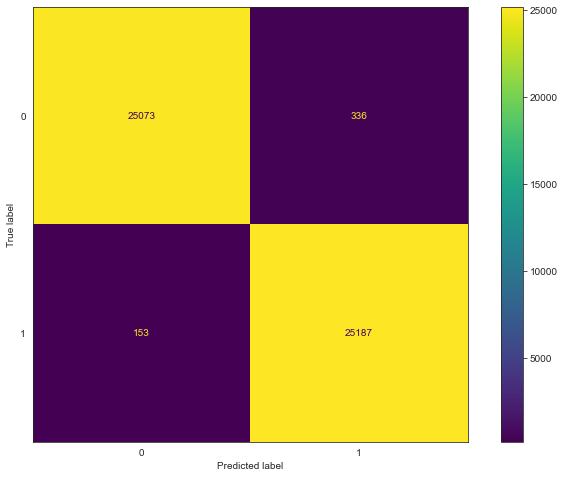

In [64]:
cm = confusion_matrix(y_teste, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Então, os **resultados estão bem melhores** que a última vez que calculamos. Conseguimos diminuir os falsos positivos de 750 para 336 e os falsos negativos de 652 para 153. Significa que estamos deixando passar apenas 153 fraudes e estamos ligando para apenas 336 pessoas.

# Conclusões

Pontos importantes para a **detecção de fraude**:


   - Tipos de movimentação **transferências e cash-out** são os com mais probabilidade de ser uma fraude. **Plano de ação**: Solicitar uma verificação de informação adicional, com uma pergunta de segurança, quando as movimentações forem do tipo transferência ou cash-out;
   
 
   - Tipos de movimentação **pagamento e cash-in** são os com menos probabilidade de ser uma fraude. 
   
   
   - Quando o padrão de compra do cliente é em determinado horário, a transação **fraude costuma ocorrer em período diferente do padrão** (ex: padrão de movimentação pela manhã - fraude pela noite, padrão de movimentação início do mês - fraude final de mês. **Plano de ação**: Uma verificação que pode aumentar a segurança do cliente em horários que não são convencionais.
   
   
   - A grande maioria das fraudes **esvaziam os fundos** do cliente 1, transferindo para outra conta e depois **sacando do sistema.** **Plano de ação**: Solicitar uma verificação de informação adicional, com uma pergunta de segurança, quando o valor da movimentação for igual ao valor total da conta;